In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import pandas as pd
from model import ode_y, ode_y_jump_approach_one
from numba import njit
from utilities import find_nearest_value

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

### Section 1.5
Please enter a plot of the $h$’s for your current parameter setting along with the optimized $\tilde{e}$
in comparison to the the case in which ξ is set to a very large number.

In [28]:
# Section 1.5.1
# Plot h and e_tilde, ξ_1m=1./4000, ξ_1m=1000
# Turn off smooth ambiguity for climate
# Low damage only

ξ_1m_list = [1/500, 1000.]
ξ_a = 1000.

η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)
σ_y = 1.2*1.86/1000

y_bar = 2.
γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p = 0  # low damage

n_y = 100
y_min = 1e-10
y_max = 10
y_grid = np.linspace(y_min, y_max, n_y)

e_tilde_list = []
h_list = []
for ξ_1m in ξ_1m_list:
    model_paras = (η, δ, θ, πc_o, σ_y, ξ_1m, ξ_a, γ_1, γ_2, γ_2p, y_bar) 
    model_res = ode_y(y_grid, model_paras, v0=None, ϵ=.5, tol=1e-8, max_iter=5_000, print_all=False)
    v0 = model_res['v0']
    e_tilde = model_res['e_tilde']
    h = 1./ξ_1m * (-model_res['v0_dy'] + (1-η)*model_res['d_Λ']) * e_tilde * σ_y
    e_tilde_list.append(e_tilde)
    h_list.append(h)

Converged. Total iteration 2206: LHS Error: 9.95852462992719e-09; RHS Error 2.400650005582837e-06
Converged. Total iteration 2215: LHS Error: 9.959568756517934e-09; RHS Error 2.6318500072685736e-06


In [29]:
def simulation(y_grid, e_grid, h_grid, θ=1.86/1000., y_start=.5394, T=100):
    Et = np.zeros(T+1)
    yt = np.zeros(T+1)
    ht = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = np.interp(y_start, y_grid, e_grid)
        ht[i] = np.interp(y_start, y_grid, h_grid)
        yt[i] = y_start
        y_start = y_start + Et[i]*θ
    return Et, yt, ht

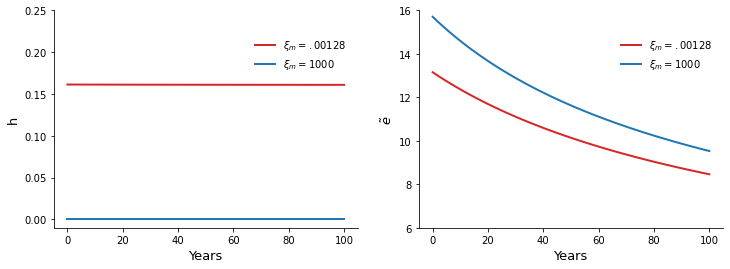

In [30]:
et_tilde_distorted, yt_distorted, ht_distorted\
    = simulation(y_grid, e_tilde_list[0], h_list[0], θ=1.86/1000., y_start=.5394, T=100)
et_tilde_baseline, yt_baseline, ht_baseline\
    = simulation(y_grid, e_tilde_list[1], h_list[1], θ=1.86/1000., y_start=.5394, T=100)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
ax1.plot(ht_distorted, color='C3', label=r'$\xi_m = .00128$', linewidth=2.)
ax1.plot(ht_baseline, color='C0', label=r'$\xi_m = 1000$', linewidth=2.)
ax1.set_xlabel('Years', fontsize=13)
ax1.set_ylabel('h', fontsize=13)
ax1.legend(frameon=False, loc=(0.65,.7))
ax1.set_ylim(-0.01, 0.25)

ax2.plot(et_tilde_distorted, color='C3', label=r'$\xi_m = .00128$', linewidth=2.)
ax2.plot(et_tilde_baseline, color='C0', label=r'$\xi_m = 1000$', linewidth=2.)
ax2.set_xlabel('Years', fontsize=13)
ax2.set_ylabel(r'$\tilde{e}$', fontsize=13)
ax2.legend(frameon=False, loc=(0.65,.7))
ax2.set_ylim(6., 16.)

fig.savefig('../plots/figure_1.pdf')

In [31]:
ht_distorted

array([0.16131672, 0.16130743, 0.1612982 , 0.16128923, 0.16128087,
       0.16127256, 0.1612643 , 0.1612561 , 0.16124861, 0.16124116,
       0.16123376, 0.1612264 , 0.16121948, 0.16121279, 0.16120614,
       0.16119953, 0.16119306, 0.16118705, 0.16118107, 0.16117512,
       0.16116921, 0.16116361, 0.16115822, 0.16115286, 0.16114753,
       0.16114223, 0.16113733, 0.16113249, 0.16112768, 0.16112289,
       0.16111816, 0.16111379, 0.16110944, 0.16110511, 0.16110081,
       0.16109657, 0.16109263, 0.16108871, 0.16108481, 0.16108093,
       0.1610771 , 0.16107354, 0.16107001, 0.16106648, 0.16106298,
       0.16105949, 0.16105626, 0.16105306, 0.16104988, 0.16104671,
       0.16104355, 0.16104056, 0.16103766, 0.16103478, 0.16103191,
       0.16102905, 0.16102625, 0.16102362, 0.16102101, 0.1610184 ,
       0.16101581, 0.16101322, 0.16101078, 0.16100841, 0.16100604,
       0.16100368, 0.16100134, 0.160999  , 0.16099684, 0.16099469,
       0.16099255, 0.16099041, 0.16098829, 0.1609862 , 0.16098

### Section 1.6
Han and Suri, drop the $h$ and only consider the smooth ambiguity. Use an ambiguity parameter as in Barnett, Brock and Hansen. Plot the distorted histograms from the climate models along with an emissions comparison with and without ambiguity aversion. Produce calculations for each of the three damage functions.

In [19]:
# Section 1.5.1
# Plot πc and e_tilde, 1) ξ_1a=1./4000, ξ_1a=1000 2) three damages
# Turn off misspecification

ξ_1m = 1000.
ξ_a_list = [1./4000, 1000]

η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)
# σ_y = 1.2*1.86/1000
σ_y = 0.

y_bar = 2.
γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p_list = [.0197, .0197*2, .3853*2]  # three damages

n_y = 100
y_min = 1e-10
y_max = 10
y_grid = np.linspace(y_min, y_max, n_y)

e_tilde_list = []
πc_list = []
for ξ_a in ξ_a_list:
    e_tilde_list_temp = []
    πc_list_temp = []
    for γ_2p in γ_2p_list:
        model_paras = (η, δ, θ, πc_o, σ_y, ξ_1m, ξ_a, γ_1, γ_2, γ_2p, y_bar) 
        model_res = ode_y(y_grid, model_paras, v0=None, ϵ=.5, tol=1e-8, max_iter=10_000, print_all=False)
        e_tilde_list_temp.append(model_res['e_tilde'])
        πc_list_temp.append(model_res['πc'])
    e_tilde_list.append(e_tilde_list_temp)
    πc_list.append(πc_list_temp)

Converged. Total iteration 1773: LHS Error: 9.963058163198202e-09; RHS Error 5.932364784177145e-06
Converged. Total iteration 2025: LHS Error: 9.96393594021594e-09; RHS Error 8.77890593556054e-06
Converged. Total iteration 2334: LHS Error: 9.967605907323929e-09; RHS Error 3.096359347256876e-05
Converged. Total iteration 1753: LHS Error: 9.972083891279793e-09; RHS Error 5.984550037635775e-06
Converged. Total iteration 2017: LHS Error: 9.9533521702444e-09; RHS Error 8.781178279204302e-06
Converged. Total iteration 2333: LHS Error: 9.975482107016376e-09; RHS Error 3.177631071494218e-05


In [20]:
et_tilde_distorted_low, yt_distorted_low, _\
    = simulation(y_grid, e_tilde_list[0][0], np.zeros_like(y_grid), θ=1.86/1000., y_start=.5394, T=100)
et_tilde_distorted_high, yt_distorted_high, _\
    = simulation(y_grid, e_tilde_list[0][1], np.zeros_like(y_grid), θ=1.86/1000., y_start=.5394, T=100)
et_tilde_distorted_extreme, yt_distorted_extreme, _\
    = simulation(y_grid, e_tilde_list[0][2], np.zeros_like(y_grid), θ=1.86/1000., y_start=.5394, T=100)

et_tilde_baseline_low, yt_baseline_low, _\
    = simulation(y_grid, e_tilde_list[1][0], np.zeros_like(y_grid), θ=1.86/1000., y_start=.5394, T=100)
et_tilde_baseline_high, yt_baseline_high, _\
    = simulation(y_grid, e_tilde_list[1][1], np.zeros_like(y_grid), θ=1.86/1000., y_start=.5394, T=100)
et_tilde_baseline_extreme, yt_baseline_extreme, _\
    = simulation(y_grid, e_tilde_list[1][2], np.zeros_like(y_grid), θ=1.86/1000., y_start=.5394, T=100)

In [21]:
def draw_from_distribution(θ, π, num=100_000):
    res = np.zeros(num)
    start = 0
    for i in range(len(π)):
        end = start + int(π[i]*num)
        res[start:end] = θ[i]
        start = end
    return res[res!=0]

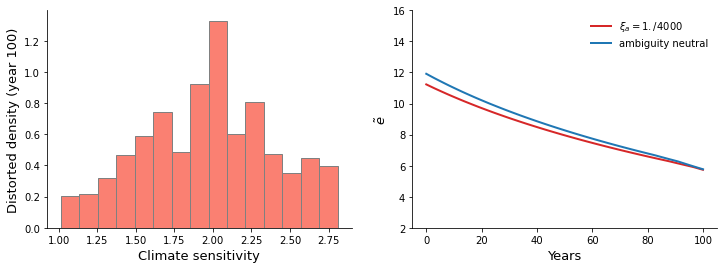

In [22]:
def plot_two(θ, y_grid, yt_distorted, πc_distorted, et_tilde_distorted, et_tilde_baseline, path):
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
    loc = find_nearest_value(y_grid, yt_distorted[100]) # histogram at year 100
    θ_distorted = draw_from_distribution(θ*1000, πc_distorted[:, loc], num=100_000)
    ax1.hist(θ_distorted, bins=15, color='salmon', histtype='bar', ec='gray', density=True)
    ax1.set_xlabel('Climate sensitivity', fontsize=13)
    ax1.set_ylabel('Distorted density (year 100)', fontsize=13)

    ax2.plot(et_tilde_distorted, color='C3', label=r'$\xi_a = 1./4000$', linewidth=2.)
    ax2.plot(et_tilde_baseline, color='C0', label='ambiguity neutral', linewidth=2.)
    ax2.set_xlabel('Years', fontsize=13)
    ax2.set_ylabel(r'$\tilde{e}$', fontsize=13)
    ax2.legend(frameon=False, loc='upper right')
    ax2.set_ylim(2, 16)

    fig.savefig(path)

plot_two(θ, y_grid, yt_distorted_low, πc_list[0][0], et_tilde_distorted_low, et_tilde_baseline_low,
         path='../plots/figure_2_low_damage.pdf')
# plot_two(θ, y_grid, yt_distorted_high, πc_list[0][1], et_tilde_distorted_high, et_tilde_baseline_high,
#          path='../plots/figure_2_high_damage.pdf')
# plot_two(θ, y_grid, yt_distorted_extreme, πc_list[0][2], et_tilde_distorted_extreme, et_tilde_baseline_extreme,
#          path='../plots/figure_2_extreme_damage.pdf')

### Section 1.7
Han and Suri, Try $\xi_m = .1$ and equal baseline probabilities for each of the three damage specifications. Do this for approach one. Please plot both the distorted probabilities and the proportionate shift in the intensity probabilities. Try a small value of $\xi$. We can adjust this later. Also plot the emissions trajectory in comparison to setting $\xi_m$ very large.

In [ ]:
ξ_1m = 1000.
ξ_2m_list = [.1, 1000]
# ξ_a = 1./4000
ξ_a = 1000

η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)
σ_y = 1.2*1.86/1000

y_bar = 2.
γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p = np.array([0, .0197*2, .3853*2])
πd_o = np.array([.475, .475, .05])

n_y = 100
y_grid_long = np.linspace(1e-10, 10, n_y)
y_grid_short = np.linspace(1e-10, 2, n_y)

In [ ]:
e_tilde_list = []
πd_list = []
g_list = []
for ξ_2m in ξ_2m_list:
    # Prepare ϕ_i
    ϕ_list = []
    for γ_2p_i in γ_2p:
        model_paras = (η, δ, θ, πc_o, σ_y, ξ_1m, ξ_a, γ_1, γ_2, γ_2p_i, y_bar) 
        model_res = ode_y(y_grid_long, model_paras, v0=None, ϵ=.5,
                           tol=1e-8, max_iter=5_000, print_all=False)
        ϕ_list.append(model_res['v0'])

    ϕ_list_short = []
    for ϕ_i in ϕ_list:
        temp = np.interp(y_grid_short, y_grid_long, ϕ_i)
        ϕ_list_short.append(temp)
    ϕ_i = np.array(ϕ_list_short)

    # Compute ϕ
    ς = .1
    model_paras = (η, δ, θ, πc_o, σ_y, ξ_1m, ξ_2m, ξ_a, ς, γ_1, γ_2, y_bar, ϕ_i, πd_o)
    ϕ, e_tilde, πc, c_entropy, g = ode_y_jump_approach_one(y_grid_short, model_paras, v0=np.average(ϕ_i, axis=0, weights=πd_o),
                                                        ϵ=.5, tol=1e-8, max_iter=10_000, print_all=False)

    # Compute worst case probabilities
    πd_o_reshape = np.zeros((len(πd_o), len(y_grid_short)))
    for i in range(πd_o_reshape.shape[0]):
        πd_o_reshape[i] = πd_o[i]
    πd = [np.exp(1./ξ_2m*(ϕ-ϕ_i[i])) * πd_o[i] for i in range(len(πd_o))]
    πd = np.array(πd)
    
    e_tilde_list.append(e_tilde)
    πd_list.append(πd)
    g_list.append(g)

In [ ]:
def simulation_jump(y_grid, e_grid, π_grid, g_grid, θ=1.86/1000., y_start=.5394, T=50):
    Et = np.zeros(T+1)
    πt = np.zeros((len(π_grid), T+1))
    yt = np.zeros(T+1)
    gt = np.zeros_like(πt)
    for i in range(T+1):
        Et[i] = np.interp(y_start, y_grid, e_grid)
        for n in range(πt.shape[0]):
            πt[n, i] = np.interp(y_start, y_grid, π_grid[n])
            gt[n, i] = np.interp(y_start, y_grid, g_grid[n])
        yt[i] = y_start
        y_start = y_start + Et[i]*θ
    return Et, yt, πt, gt

In [ ]:
et_tilde_distorted, yt_distorted, πt_distorted, gt_distorted\
    = simulation_jump(y_grid_short, e_tilde_list[0], πd_list[0], g_list[0], θ=1.86/1000., y_start=.5394, T=80)
et_tilde_baseline, yt_baseline, πt_baseline, gt_baseline\
    = simulation_jump(y_grid_short, e_tilde_list[1], πd_list[1], g_list[1], θ=1.86/1000., y_start=.5394, T=80)

ι_y = np.average(gt_distorted, axis=0, weights=πd_o)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
ax1.plot(πt_distorted[0]/ι_y, color='C3', label='low damage', linewidth=2.)
ax1.plot(πt_distorted[1]/ι_y, color='C0', label='high damage', linewidth=2.)
ax1.plot(πt_distorted[2]/ι_y, color='C1', label='extreme damage', linewidth=2.)
ax1.set_xlabel('Years', fontsize=13)
ax1.set_ylabel('Distorted probability', fontsize=13)
ax1.legend(frameon=False)
ax1.set_ylim(0, .6)

ax2.plot(ι_y, color='black', linewidth=2.)
ax2.set_xlabel('Years', fontsize=13)
ax2.set_ylabel('Proportional change in intensity', fontsize=13)
ax2.set_ylim(.98, 1.)

fig.savefig('../plots/figure_3.pdf')

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(et_tilde_distorted, color='C3', label=r'$\xi_m = .1$', linewidth=2.)
plt.plot(et_tilde_baseline, color='C0', label=r'$\xi_m = 1000$', linewidth=2.)
plt.xlabel('Years', fontsize=13)
plt.ylabel(r'$\tilde{e}$', fontsize=13)
plt.legend(frameon=False)
plt.ylim(2., 16.)
plt.savefig('../plots/figure_4.pdf')